# Grover's Algorithm with hierarcqal


In [1]:
import sys
sys.path.append('c:\\Users\\Amy\\Desktop\\Green_Git\\hierarqcal')

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qinit,
    Qmask,
    Qunitary,
    Qpivot,
    Qcycle,
    Qunmask
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [3]:
backend = "qiskit"

### Some backend dependant helper functions

In [4]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Background


## Choose the number of qubits

In [5]:
n = 8
N = 2**(2*(n)-3)

In [6]:
random_int = np.random.randint(0, N)
Target_string = bin(random_int)[2:].zfill(n)


In [7]:
print(int((np.pi/2*np.sqrt(N)-1)/2), 'interactions of Grover')
print('With target',Target_string)
print('Search space size',N, 'Qubit', 2*(n)-3)

70 interactions of Grover
With target 1010011111010
Search space size 8192 Qubit 13


## Primitive circuit 


## Create the primitive circuit with Qpivot

In [14]:
# Ration around the zero state but an angle of pi
H = Qunitary("H()^0")
X = Qunitary("X()^0")
H_bottom = Qpivot(mapping=H, global_pattern="*1")

U_psi = Qcycle(mapping=H)
U_T = Qpivot(mapping=X, global_pattern=Target_string)
U_t = Qpivot(mapping=H, global_pattern="*1")
U_t += Qpivot(
    mapping=Qunitary("cp(x)^01", symbols=[np.pi / 2]),
    global_pattern="*1",
    merge_within="1*",
)
U_t += Qpivot(
    mapping=Qunitary("cnot()^01;cp(x)^12;cnot()^01", symbols=[np.pi / 2]),
    global_pattern="*1",
    merge_within="*1",
)
U_t += Qpivot(mapping=H, global_pattern="*1")

U_toffoli = Qinit(3) + U_t

maskAncillas = Qmask('0'+'01'*(n-3)+'00')
multiCZ = Qcycle(step=2, mapping=U_toffoli, boundary="open") + Qmask('*1') + Qcycle(step = 2, mapping=U_toffoli,share_weights=True, boundary="open", edge_order = [-1]) + Qunmask('previous')

U_rotate = H_bottom + Qunmask('previous') + multiCZ + maskAncillas + H_bottom 

U_oracle = U_T + U_rotate + U_T
U_defuse = U_psi + U_rotate + U_psi

ancilla_str = '0'+'01'*(n-3)+'00'
q_names = [f'q_{i}' if ancilla_str[i]== '0' else f'a_{i}' for i in range(2*n-3)]
U = Qinit(q_names) + U_psi + (maskAncillas + U_oracle + U_defuse)*2#int((np.pi/2*np.sqrt(N)-1)/2)



In [22]:
# list(U.get_symbols())
# U.set_symbols(np.array([np.pi/2]*U.n_symbols))

In [20]:
# create the circuit using the chose backend
circuit= U(backend=backend, barriers=True)

UnboundLocalError: cannot access local variable 'state' where it is not associated with a value

## Visualize the primitive circuit

Change the value of k to convince yourself that is indeed works as intended.

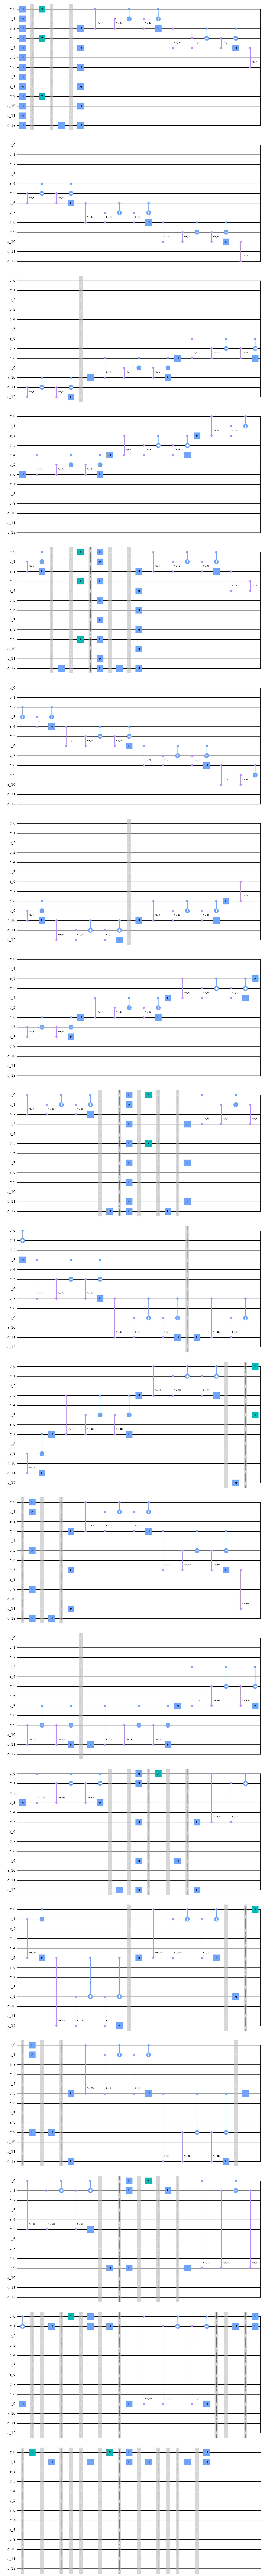

In [10]:
circuit.draw("mpl")

In [11]:
# run the circuit, get counts
from qiskit import Aer, execute
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('qasm_simulator')
job = execute(circuit, backend, shots=1000)
result = job.result()
counts = result.get_counts(circuit)

plot_histogram(counts)



AerError: 'circuits have parameters but parameter_binds is not specified.'